# Multi-Layer Perceptron, MNIST
---
In this notebook, we will train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

The process will be broken down into the following steps:
>1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

Before we begin, we have to import the necessary libraries for working with data and PyTorch.

In [0]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models

---
## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the `batch_size` if you want to load more data at a time.

This cell will create DataLoaders for each of our datasets.

In [4]:
from torch.utils.data import DataLoader

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# define transform Object
transform = transforms.ToTensor() # convert data to torch.FloatTensor

# download pytorch MNIST training and test set
train_data = datasets.MNIST(root='data/', train=True, # using MNIST/processed/training.pt
                           download=True, transform=transform)
test_data = datasets.MNIST(root='data/', train=False, # using MNIST/processed/test.pt
                          download=True, transform=transform)

# prepare data loader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=0)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

0it [00:00, ?it/s]

9920512it [00:02, 3603378.28it/s]                             


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 56099.80it/s]                           
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:01, 943191.00it/s]                            
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 21097.21it/s]            

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


### Visualize a Batch of Training Data

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

torch.Size([20, 1, 28, 28])


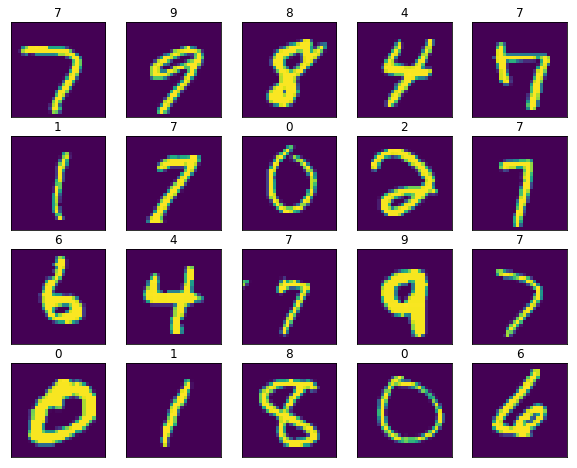

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(train_loader) # get iterator for train_loader object
images, labels = next(dataiter)

print(images.shape)

# plot the figure of MNIST images in a batch, along with corresponding labels
fig = plt.figure(figsize=(10,8))

for idx, image in enumerate(images):
    # make figure of 4x5
    ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
    ax.imshow(image.squeeze())
    ax.set_title(str(labels[idx].item()))

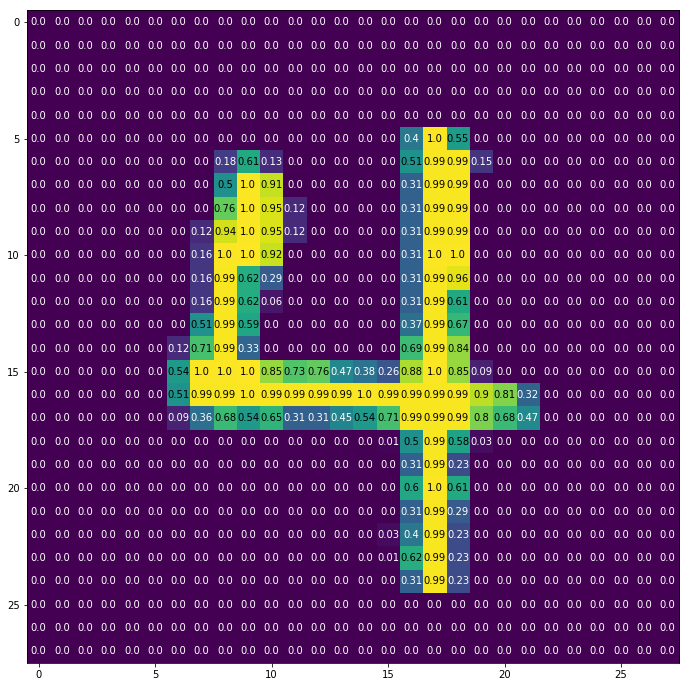

In [20]:
img = images.numpy().squeeze()[12] # pick any from 0-19
width, height = img.shape

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img)

thresh_color = img.max()/2
for i in range(width):
    for j in range(height):
        val = round(img[i][j], 2)
        ax.annotate(str(val), xy=(j,i),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[i][j]<thresh_color else 'black')

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

The architecture will be responsible for seeing as input a 784-dim Tensor of pixel values for each image, and producing a Tensor of length 10 (our number of classes) that indicates the class scores for an input image. This particular example uses two hidden layers and dropout to avoid overfitting.

In [126]:
class MLPNet(nn.Module):
    def __init__(self, input_size, hidden_layer_sizes, num_classes=10, drop_p=0.5):
        """Initialise a network of fully connected/MLP layers with specification
        Arguments:
            ______________________
            - input_size: (int or tuple) size/dimension of input matrix per img.
            - hidden_layer_sizes: (list) channel lengths of linear layers.
            - num_classes: (int) number of classes to classify.
            - drop_p: (float; 0<=p<=1) dropout layer probability.
        """
        super(MLPNet, self).__init__()

        # Verify input size
        
        if isinstance(input_size, int):
            self.input_size = int(input_size)
            
        elif isinstance(input_size, (list,tuple)):
            self.input_size = np.prod(input_size)
            
        else:
            raise Exception(f"Input size: {input_size} expect integer or"
                            " tuple to specify dimension.")
        
        # Define Input layers
        self.hidden_layers = nn.ModuleList([nn.Linear(self.input_size, hidden_layer_sizes[0])])
        
        # Add more hidden layers
        hh = zip(hidden_layer_sizes[:-1], hidden_layer_sizes[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in hh])
        
        self.output = nn.Linear(hidden_layer_sizes[-1], num_classes)
        
        self.dropout = nn.Dropout(p=drop_p)
        
 
    def forward(self, X):
        """ Feed forward raw input to models
        Arguments
            ______________________
            input: Vectors or Matrices of input data
        """
        # Batch size
        X = X.view(-1, self.input_size)
        
        # Forward flow
        for layer in self.hidden_layers:
            X = F.relu(layer(X))
            X = self.dropout(X)
            
        X = self.output(X) # sobel of output layer
        
        return F.log_softmax(X, dim=1)

model = MLPNet(img.shape, [512, 512], num_classes=10, drop_p=0.5)
print(model)

MLPNet(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
  )
  (output): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.5)
)


###  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer *and* then calculates the log loss.

In [0]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

### Train the Network
The steps for training/learning from a batch of data are described in the comments below:

1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

The following loop trains for 50 epochs; take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data.

In [128]:
# number of epochs to train the model
n_epochs = 20

model.train() # prepare model for training session

for epoch in range(n_epochs):
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, targets in train_loader:
        # reset gradient on optimizer
        optimizer.zero_grad()
        # forward pass: predicting outputs by passing input to model
        output = model(data) # output is probability of 10 target classes
        # calculate the loss
        loss = criterion(output, targets)
        # backpropagate pass: propagate gradient of the loss
        loss.backward()
        # perform weight update
        optimizer.step()
        
        # update training loss
        train_loss += loss.item() * data.size(0)
    
    # print train_loss
    train_loss = train_loss/len(train_loader.sampler)
    print("Epoch {}: \t Training Loss: {: .6f}".format(
        epoch+1,
        train_loss))


Epoch 1: 	 Training Loss:  0.954085
Epoch 2: 	 Training Loss:  0.375182
Epoch 3: 	 Training Loss:  0.288218
Epoch 4: 	 Training Loss:  0.236570
Epoch 5: 	 Training Loss:  0.204828
Epoch 6: 	 Training Loss:  0.180585
Epoch 7: 	 Training Loss:  0.161817
Epoch 8: 	 Training Loss:  0.147430
Epoch 9: 	 Training Loss:  0.138029
Epoch 10: 	 Training Loss:  0.125878
Epoch 11: 	 Training Loss:  0.116456
Epoch 12: 	 Training Loss:  0.110436
Epoch 13: 	 Training Loss:  0.104481
Epoch 14: 	 Training Loss:  0.099568
Epoch 15: 	 Training Loss:  0.093349
Epoch 16: 	 Training Loss:  0.089520
Epoch 17: 	 Training Loss:  0.085877
Epoch 18: 	 Training Loss:  0.081729
Epoch 19: 	 Training Loss:  0.079661
Epoch 20: 	 Training Loss:  0.073608



###  Defining [Network Architecture](http://pytorch.org/docs/stable/nn.html)
We will be using an Convolutional Neural Network. We will use the following architecture:
* [Convolutional layers](https://pytorch.org/docs/stable/nn.html#conv2d), which can be thought of as stack of filtered images.
* [Maxpooling layers](https://pytorch.org/docs/stable/nn.html#maxpool2d), which reduce the size of the input matrix, which only keeps the most active pixels from prev layer.
* The usual Linear + Dropout layers to avoid overfitting and produce a 10-dim output.
A network with 2 convolutional layers is shown in the image below and in the code, and you've been given starter code with one convolutional and one maxpooling layer.

### Test the Trained Network
Finally, we test our best model on previously unseen test data and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

In [0]:
test_loss = 0.0

model.eval() # prepare model for validation
class_correct = [0.0] * 10
class_total = [0.0] * 10

for data, targets in test_loader:
    # forward pass: compute predicted output
    output = model(data) # output is probability of 10 target classes
    # calculate loss and save
    loss = criterion(output, targets)
    # convert output probabilities to prediction inference
    _, pred = torch.max(output, 1)
    test_loss += loss.item()* data.size(0)

    # calculate test accuracy for each subject class
    is_correct = pred.numpy() == targets.numpy()
    for i in range(len(targets)):
        label = targets.data[i]
        class_total[label] += 1
        if is_correct[i]:
            class_correct[label] += 1


In [132]:
# calculate avg test loss for one testset
test_loss = test_loss/len(test_loader.sampler)
print("Test Loss: {: .6f}\n".format(test_loss))

for i in range(len(class_total)):
    if class_total[i] != 0:
        print("Test accuracy/class {}: {:.6f}% ({}/{})".format(
            i,
            class_correct[i]/class_total[i],
            class_correct[i],
            class_total[i]
        ))

# calculate overall accuracy
n_correct = np.sum(class_correct)
print("Overall test accuracy: {:.6f}% ({}/{})".format(
    n_correct / len(test_loader.sampler),
    n_correct,
    np.sum(class_total)
))

Test Loss:  0.066216

Test accuracy/class 0: 0.991837% (972.0/980.0)
Test accuracy/class 1: 0.992070% (1126.0/1135.0)
Test accuracy/class 2: 0.981589% (1013.0/1032.0)
Test accuracy/class 3: 0.981188% (991.0/1010.0)
Test accuracy/class 4: 0.979633% (962.0/982.0)
Test accuracy/class 5: 0.976457% (871.0/892.0)
Test accuracy/class 6: 0.980167% (939.0/958.0)
Test accuracy/class 7: 0.975681% (1003.0/1028.0)
Test accuracy/class 8: 0.971253% (946.0/974.0)
Test accuracy/class 9: 0.967294% (976.0/1009.0)
Overall test accuracy: 0.979900% (9799.0/10000.0)


### Visualize Sample Test Results
This cell displays test images and their labels in this format: predicted (ground-truth). The text will be green for accurately classified examples and red for incorrect predictions.

torch.Size([20, 1, 28, 28])


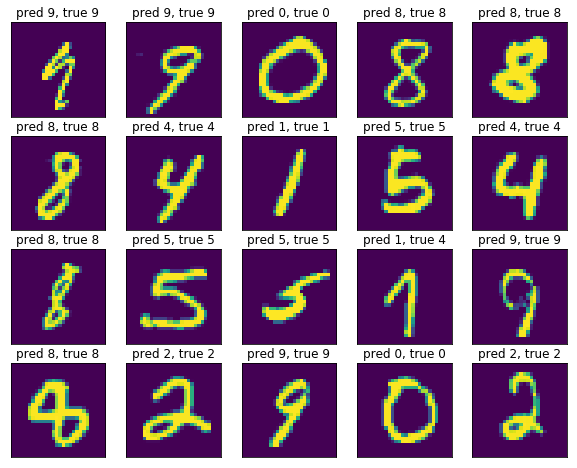

In [119]:
dataiter = iter(train_loader) # get iterator for train_loader object
images, labels = next(dataiter)

# forward pass: predict output
output = model(images)
_, pred = torch.max(output, 1)

print(images.shape)

# plot the figure of MNIST images in a batch, along with corresponding labels
fig = plt.figure(figsize=(10,8))

for idx, image in enumerate(images):
    # make figure of 4x5
    ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
    ax.imshow(image.squeeze())
    ax.set_title("pred {}, true {}".format(
        labels[idx].item(),
        pred[idx].item()
    ))

#### Hidden layers: (64, 32, 20, 16) - 20 epochs
- Test accuracy/class 0: 0.942857% (924.0/980.0)
- Test accuracy/class 1: 0.976211% (1108.0/1135.0)
- Test accuracy/class 2: 0.929264% (959.0/1032.0)
- Test accuracy/class 3: 0.954455% (964.0/1010.0)
- Test accuracy/class 4: 0.940937% (924.0/982.0)
- Test accuracy/class 5: 0.939462% (838.0/892.0)
- Test accuracy/class 6: 0.968685% (928.0/958.0)
- Test accuracy/class 7: 0.931907% (958.0/1028.0)
- Test accuracy/class 8: 0.936345% (912.0/974.0)
- Test accuracy/class 9: 0.922696% (931.0/1009.0)

Overall test accuracy: 0.944600% (9446.0/10000.0)

#### Hidden layers: (512, 512) - 20 epochs
- Test accuracy/class 0: 0.991837% (972.0/980.0)
- Test accuracy/class 1: 0.992070% (1126.0/1135.0)
- Test accuracy/class 2: 0.981589% (1013.0/1032.0)
- Test accuracy/class 3: 0.981188% (991.0/1010.0)
- Test accuracy/class 4: 0.979633% (962.0/982.0)
- Test accuracy/class 5: 0.976457% (871.0/892.0)
- Test accuracy/class 6: 0.980167% (939.0/958.0)
- Test accuracy/class 7: 0.975681% (1003.0/1028.0)
- Test accuracy/class 8: 0.971253% (946.0/974.0)
- Test accuracy/class 9: 0.967294% (976.0/1009.0)

Overall test accuracy: 0.979900% (9799.0/10000.0)